# ThinkBrake: Token Length Experiment

## Import and Configs

In [65]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
from pathlib import Path
import seaborn as sns

plt.style.use("seaborn-v0_8-whitegrid")
plt.rcParams.update(
    {
        "figure.figsize": (18, 8),
        "font.size": 11,
        "axes.titlesize": 14,
        "axes.labelsize": 12,
        "xtick.labelsize": 10,
        "ytick.labelsize": 10,
        "legend.fontsize": 10,
        "figure.dpi": 100,
        "axes.spines.top": False,
        "axes.spines.right": False,
        "font.family": "sans-serif",
    }
)

model_colors = sns.color_palette("dark", 8)
benchmark_colors = sns.color_palette("dark", 10)
method_palette = {
    "Baseline": "#2C3E50",
    "Thinkless": "#E74C3C",
    "ThinkBrake": "#3498DB",
}
threshold_palette = sns.color_palette("Blues", 6)[1:]
bar_colors = [
    "#123A5A",
    "#1F5F8B",
    "#3F7FBF",
    "#7AAAD6",
    "#C6DCF0",
    "#F5B7B1",
    "#F1948A",
    "#EC7063",
    "#E74C3C",
    "#B03A2E",
]
line_colors = [
    "#0A2463",
    "#1E88E5",
    "#64B5F6",
    "#BBDEFB",
    "#E3F2FD",
    "#B9770E",
    "#117A65",
    "#6C3483",
    "#1F618D",
]

markers = ["o", "s", "^", "D", "v", "p", "h", "*"]

model_name_map = {}
short_names = {}

In [66]:
def calc_subplot_layout(n_items, max_cols=4):
    if n_items == 0:
        return 1, 1, (6, 4)

    cols = min(n_items, max_cols)
    rows = math.ceil(n_items / cols)
    fig_width = 5.5 * cols
    fig_height = 4.5 * rows
    return rows, cols, (fig_width, fig_height)


def create_dynamic_subplots(n_items, max_cols=4, sharey=False):
    rows, cols, figsize = calc_subplot_layout(n_items, max_cols)
    fig, axes = plt.subplots(rows, cols, figsize=figsize, sharey=sharey)

    if n_items == 1:
        axes = np.array([axes])
    else:
        axes = np.array(axes).flatten()

    for i in range(n_items, len(axes)):
        axes[i].set_visible(False)

    return fig, axes


def add_value_labels(ax, bars, fmt=".1f", rotation=0, fontsize=9, offset=0.5):
    for bar in bars:
        height = bar.get_height()
        if height > 0:
            ax.annotate(
                f"{height:{fmt}}",
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, offset),
                textcoords="offset points",
                ha="center",
                va="bottom",
                fontsize=fontsize,
                rotation=rotation,
            )


def format_model_name(name, short_names):
    return short_names.get(name, name.split("/")[-1])


def load_detailed_results(model_dir, benchmark, method="rollout"):
    base_path = Path(f"../output/{model_dir}")
    math_benchmarks = ["gsm8k", "math500", "aime2024", "aime2025"]
    general_benchmarks = ["gpqa-diamond", "arc-challenge"]

    if benchmark in math_benchmarks:
        category = "math"
    elif benchmark in general_benchmarks:
        category = "general"
    else:
        return None

    if method == "rollout":
        file_path = base_path / category / "rollout" / f"{benchmark}_result.jsonl"
    else:
        file_path = (
            base_path / category / "thinkbrake" / method / f"{benchmark}_result.jsonl"
        )

    if not file_path.exists():
        return None

    results = []
    with open(file_path, "r") as f:
        for line in f:
            if line.strip():
                results.append(json.loads(line))
    return results

## Load Dataset

In [67]:
INCLUDE_MODELS = [
    # "Qwen_Qwen3-4B-Thinking-2507",
    # "Qwen_Qwen3-4B",
    # "Qwen_Qwen3-14B",
    "Qwen_Qwen3-32B",
    "deepseek-ai_DeepSeek-R1-Distill-Qwen-7B",
    "microsoft_phi-4-reasoning",
]

INCLUDE_BENCHMARKS = [
    "gsm8k",
    "math500",
    "aime2024",
    "aime2025",
    "gpqa-diamond",
    "arc-challenge",
    "bfcl-v1",
    "bfcl-v2",
    "meta-tool",
]

INCLUDE_THRESHOLDS = [
    # "0.01",
    "0.1",
    "0.25",
    "1.0",
    "2.5",
    # "10.0",
    # "25.0",
]

BEST_THRESHOLD = 0.1

In [68]:
PROJECT_ROOT = Path("..").resolve()
METRICS_PATH = PROJECT_ROOT / "metrics_summary.jsonl"

rows = []
with open(METRICS_PATH, "r", encoding="utf-8") as f:
    for line in f:
        line = line.strip()
        if not line:
            continue
        rows.append(json.loads(line))

df_metrics = pd.DataFrame(rows)
df_metrics = df_metrics[df_metrics["sub_category"].isna()].copy()
df_metrics = df_metrics[df_metrics["model"].isin(INCLUDE_MODELS)].copy()
df_metrics = df_metrics[df_metrics["benchmark"].isin(INCLUDE_BENCHMARKS)].copy()

benchmarks = INCLUDE_BENCHMARKS
thresholds = sorted(INCLUDE_THRESHOLDS, key=lambda x: float(x))


def _model_key(model_dir: str) -> str:
    return model_name_map.get(model_dir, model_dir)


rollout_data = {}
thinkbrake_data = {}

df_rollout = df_metrics[
    (df_metrics["method"] == "rollout") & (df_metrics["threshold"].isna())
]
for _, r in df_rollout.iterrows():
    mk = _model_key(r["model"])
    rollout_data.setdefault(mk, {})
    rollout_data[mk][r["benchmark"]] = {
        "accuracy": float(r.get("accuracy", 0.0) or 0.0),
        "avg_token_length": float(r.get("avg_token_length", 0.0) or 0.0),
    }

df_tb = df_metrics[
    (df_metrics["method"] == "thinkbrake") & (~df_metrics["threshold"].isna())
]
for _, r in df_tb.iterrows():
    mk = _model_key(r["model"])
    try:
        t = float(r["threshold"])
    except Exception:
        continue
    t_str = str(t)
    if t_str not in INCLUDE_THRESHOLDS:
        continue
    thinkbrake_data.setdefault(mk, {})
    thinkbrake_data[mk].setdefault(r["benchmark"], {})
    thinkbrake_data[mk][r["benchmark"]][f"threshold_{t_str}"] = {
        "accuracy": float(r.get("accuracy", 0.0) or 0.0),
        "avg_token_length": float(r.get("avg_token_length", 0.0) or 0.0),
    }

filtered_rollout_data = {
    k: v
    for k, v in rollout_data.items()
    if k in [model_name_map.get(m, m) for m in INCLUDE_MODELS]
}
filtered_thinkbrake_data = {
    k: v
    for k, v in thinkbrake_data.items()
    if k in [model_name_map.get(m, m) for m in INCLUDE_MODELS]
}
baseline_data = filtered_rollout_data

print("Data loaded successfully!")

Data loaded successfully!


## Token Length by Threshold

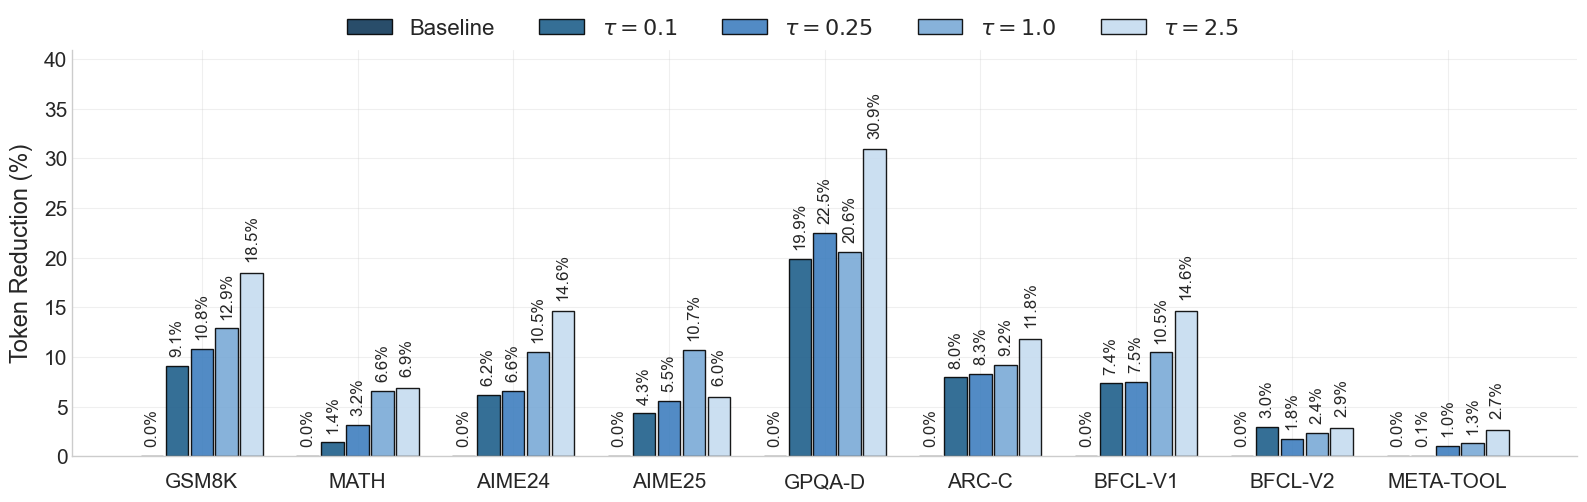

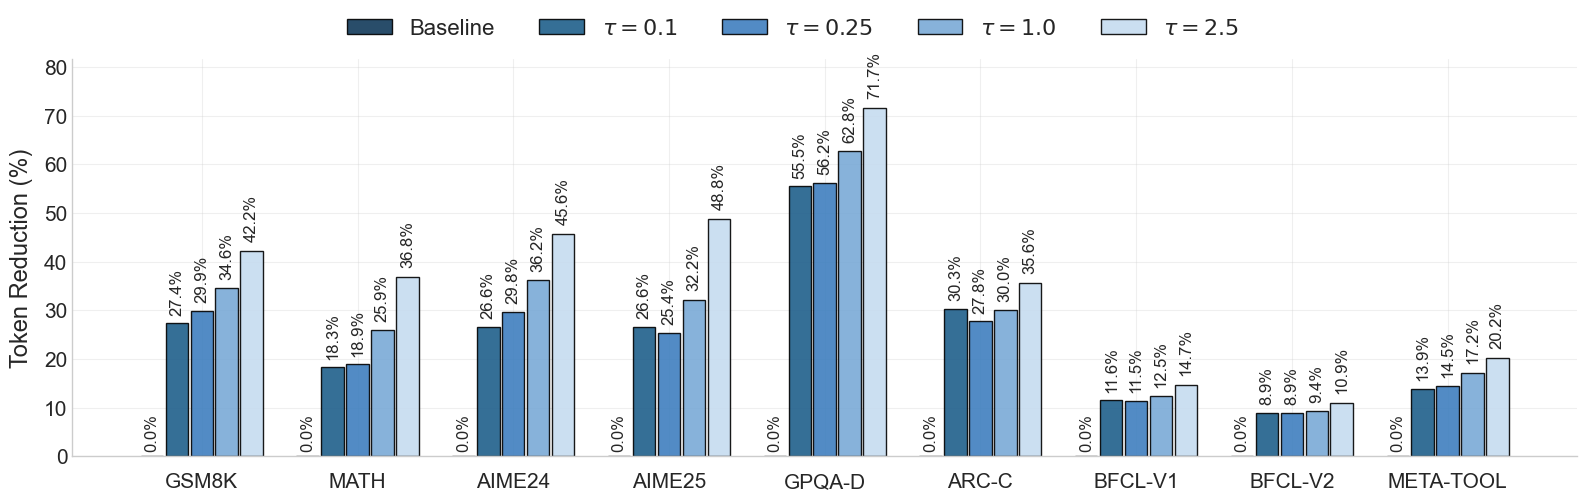

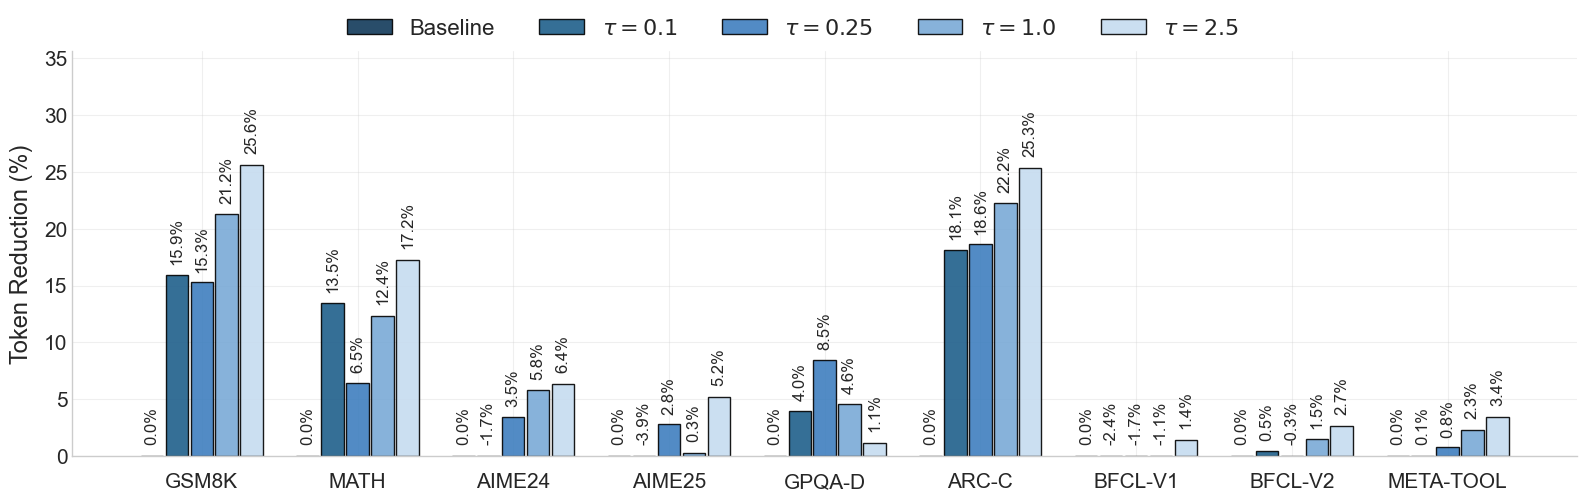

In [69]:
# Define model name mapping
short_names = {
    "Qwen_Qwen3-4B-Thinking-2507": "Qwen3-4B-Thinking",
    "Qwen_Qwen3-4B": "Qwen3-4B",
    "Qwen_Qwen3-14B": "Qwen3-14B",
    "Qwen_Qwen3-32B": "Qwen3-32B",
    "deepseek-ai_DeepSeek-R1-Distill-Qwen-7B": "DeepSeek-R1-7B",
    "microsoft_phi-4-reasoning": "Phi-4-Reasoning",
}

# Benchmark name mapping
benchmark_name_map = {
    "gpqa-diamond": "GPQA-D",
    "arc-challenge": "ARC-C",
    "math500": "MATH",
    "aime2024": "AIME24",
    "aime2025": "AIME25",
    "bfcl-v1": "BFCL-V1",
    "bfcl-v2": "BFCL-V2",
    "meta-tool": "META-TOOL",
}

# Define benchmark order (FORCED ORDER) - using official keys
benchmark_order = [
    "gsm8k",
    "math500",
    "aime2024",
    "aime2025",
    "gpqa-diamond",
    "arc-challenge",
    "bfcl-v1",
    "bfcl-v2",
    "meta-tool",
]

available_models = [m for m in INCLUDE_MODELS if _model_key(m) in thinkbrake_data]
for model in available_models:
    mk = _model_key(model)
    benchmarks_in_model = list(thinkbrake_data[mk].keys())
    n_benchmarks = len(benchmarks_in_model)
    if n_benchmarks == 0:
        continue

    # Get all threshold values
    first_benchmark = benchmarks_in_model[0]
    tb_data = thinkbrake_data[mk][first_benchmark]
    sorted_thresh_keys = sorted(tb_data.keys(), key=lambda x: float(x.split("_")[1]))
    thresholds = [k.split("_")[1] for k in sorted_thresh_keys]
    methods = ["Baseline"] + [rf"$\tau={t}$" for t in thresholds]

    fig, ax = plt.subplots(1, 1, figsize=(16, 5))
    display_name = short_names.get(mk, mk)

    # Force benchmark ordering - only include benchmarks that exist in data
    benchmarks_sorted = [b for b in benchmark_order if b in benchmarks_in_model]

    model_benchmarks = []
    model_token_reductions = {m: [] for m in methods}

    for benchmark in benchmarks_sorted:
        # Apply name mapping
        display_benchmark = benchmark_name_map.get(benchmark, benchmark).upper()
        model_benchmarks.append(display_benchmark)

        base_val = rollout_data[mk][benchmark]["avg_token_length"]

        # Baseline has 0% reduction
        model_token_reductions["Baseline"].append(0.0)

        tb_data = thinkbrake_data[mk][benchmark]
        for thresh in thresholds:
            key = f"threshold_{thresh}"
            if key in tb_data:
                thresh_val = tb_data[key]["avg_token_length"]
                # Calculate reduction percentage: (baseline - method) / baseline * 100
                reduction = (
                    ((base_val - thresh_val) / base_val * 100) if base_val > 0 else 0
                )
                model_token_reductions[rf"$\tau={thresh}$"].append(reduction)
            else:
                model_token_reductions[rf"$\tau={thresh}$"].append(0)

    # Calculate max value across all methods for dynamic y-axis
    max_reduction = max(max(vals) for vals in model_token_reductions.values() if vals)
    y_max = max_reduction + 10  # Add 10 percentage points

    x = np.arange(len(model_benchmarks))
    n_methods = len(methods)
    width = 0.8 / n_methods

    for i, method in enumerate(methods):
        if not model_token_reductions[method]:
            continue
        bars = ax.bar(
            x + (i - n_methods / 2 + 0.5) * width,
            model_token_reductions[method],
            width * 0.9,
            label=method,
            color=bar_colors[i % len(bar_colors)],
            edgecolor="black",
            alpha=0.9,
        )
        max_val = max(model_token_reductions[method])
        for bar_idx, (bar, val) in enumerate(zip(bars, model_token_reductions[method])):
            # Add a small offset for 0% values to lift them off the x-axis
            if val < 0.1:  # Close to 0
                y_offset = -val + 1
            else:
                y_offset = max_val * 0.02 + 0.5

            ax.text(
                bar.get_x() + bar.get_width() / 2,
                bar.get_height() + y_offset,
                f"{val:.1f}%",
                ha="center",
                va="bottom",
                fontsize=12,
                rotation=90,
            )

    ax.set_ylabel("Token Reduction (%)", fontsize=17, labelpad=8)
    ax.set_ylim(0, y_max)
    ax.set_xticks(x)
    ax.set_xticklabels(model_benchmarks, fontsize=15)
    ax.tick_params(axis="x", pad=12)
    ax.tick_params(axis="y", labelsize=15)

    ax.grid(True, axis="y", alpha=0.3)
    ax.grid(True, axis="x", alpha=0.3)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    # Legend at top outside
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(
        handles,
        labels,
        loc="upper center",
        bbox_to_anchor=(0.5, 1.02),
        ncol=len(methods),
        frameon=False,
        fontsize=16,
    )

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    output_path = f"../assets/{display_name}_avg_token_length.pdf"
    plt.savefig(output_path, format="pdf", bbox_inches="tight", dpi=300)
    plt.show()
    plt.close(fig)

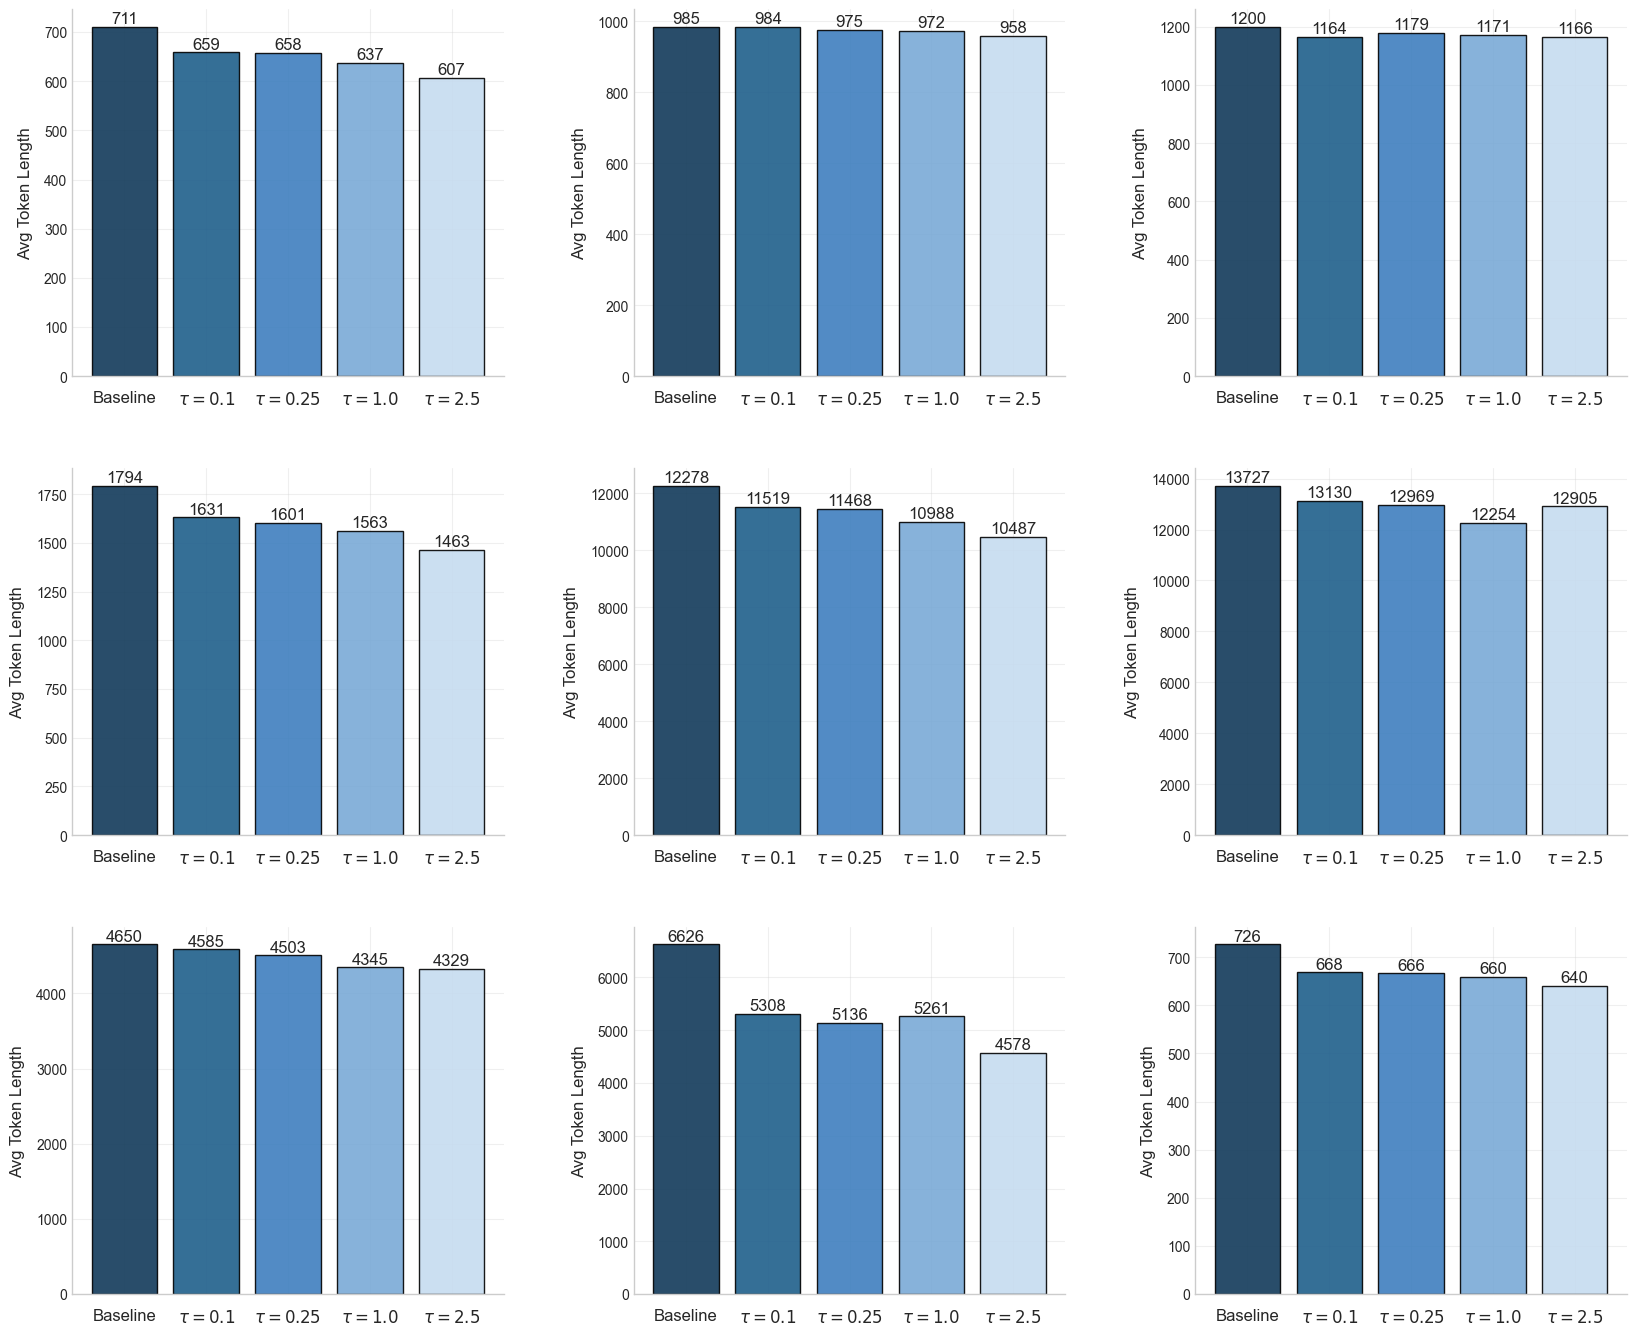

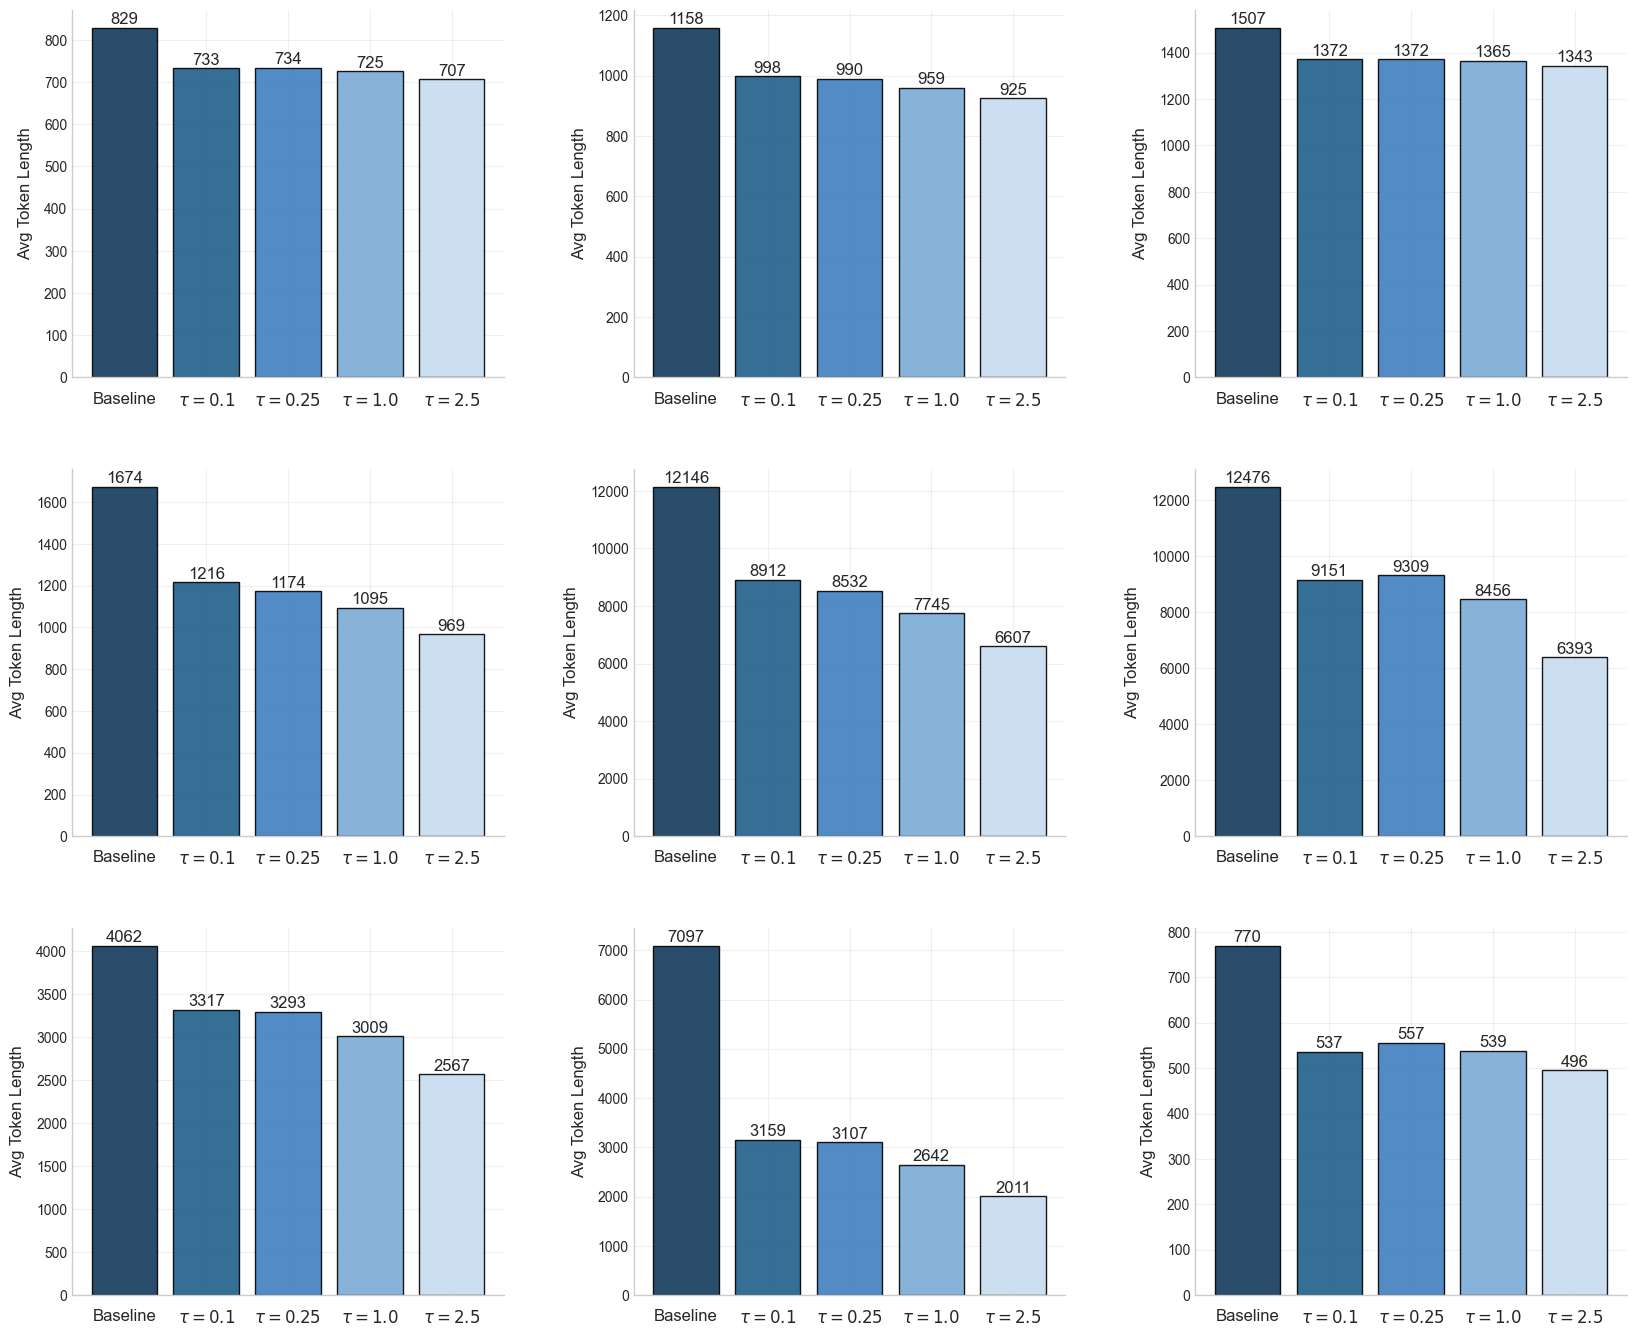

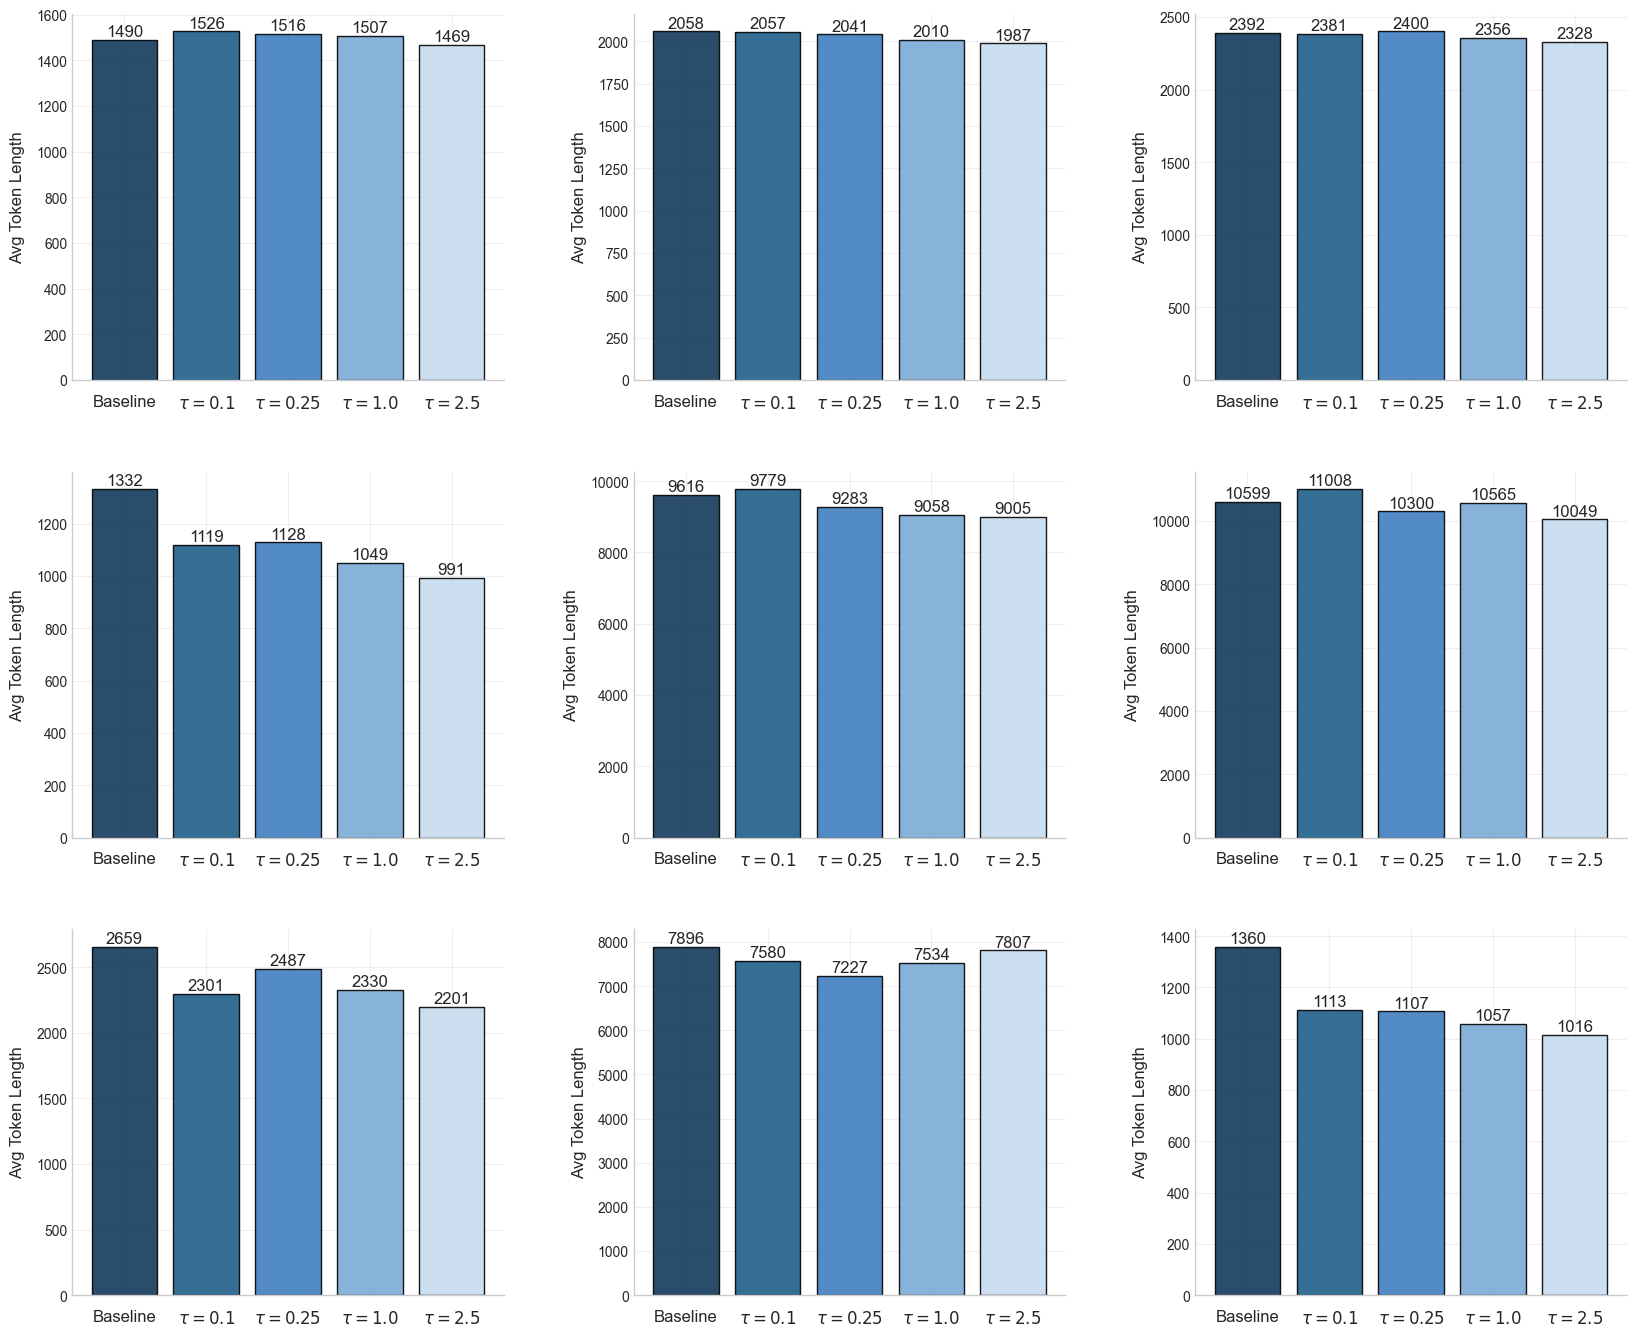

In [70]:
available_models = [m for m in INCLUDE_MODELS if _model_key(m) in thinkbrake_data]

for model in available_models:
    mk = _model_key(model)

    benchmarks_in_model = list(thinkbrake_data[mk].keys())
    n_benchmarks = len(benchmarks_in_model)
    if n_benchmarks == 0:
        continue

    fig, axes = create_dynamic_subplots(n_benchmarks, max_cols=3)

    for idx, benchmark in enumerate(benchmarks_in_model):
        ax = axes[idx]

        # Prepare data
        base_val = rollout_data[mk][benchmark]["avg_token_length"]
        tb_data = thinkbrake_data[mk][benchmark]

        sorted_thresh_keys = sorted(
            tb_data.keys(), key=lambda x: float(x.split("_")[1])
        )

        labels = ["Baseline"] + [
            rf"$\tau={k.split('_')[1]}$" for k in sorted_thresh_keys
        ]
        values = [base_val] + [
            tb_data[k]["avg_token_length"] for k in sorted_thresh_keys
        ]

        x = np.arange(len(labels))
        bars = ax.bar(
            x,
            values,
            color=bar_colors[: len(values)],
            edgecolor="black",
            alpha=0.9,
        )

        ax.set_xticks(x)
        ax.set_xticklabels(labels, fontsize=12)
        ax.set_ylabel("Avg Token Length", fontsize=12, labelpad=8)

        ax.tick_params(axis="x", labelsize=12, pad=10)
        add_value_labels(ax, bars, fmt=".0f", fontsize=12)

        ax.set_title("")
        ax.grid(True, axis="y", alpha=0.3)
        ax.grid(True, axis="x", alpha=0.3)

    plt.tight_layout()
    plt.subplots_adjust(wspace=0.3, hspace=0.25)

    display_name = short_names.get(mk, mk)
    output_path = f"../assets/{display_name}_avg_token_length.pdf"
    plt.savefig(output_path, format="pdf", bbox_inches="tight")
    plt.show()
    plt.close()

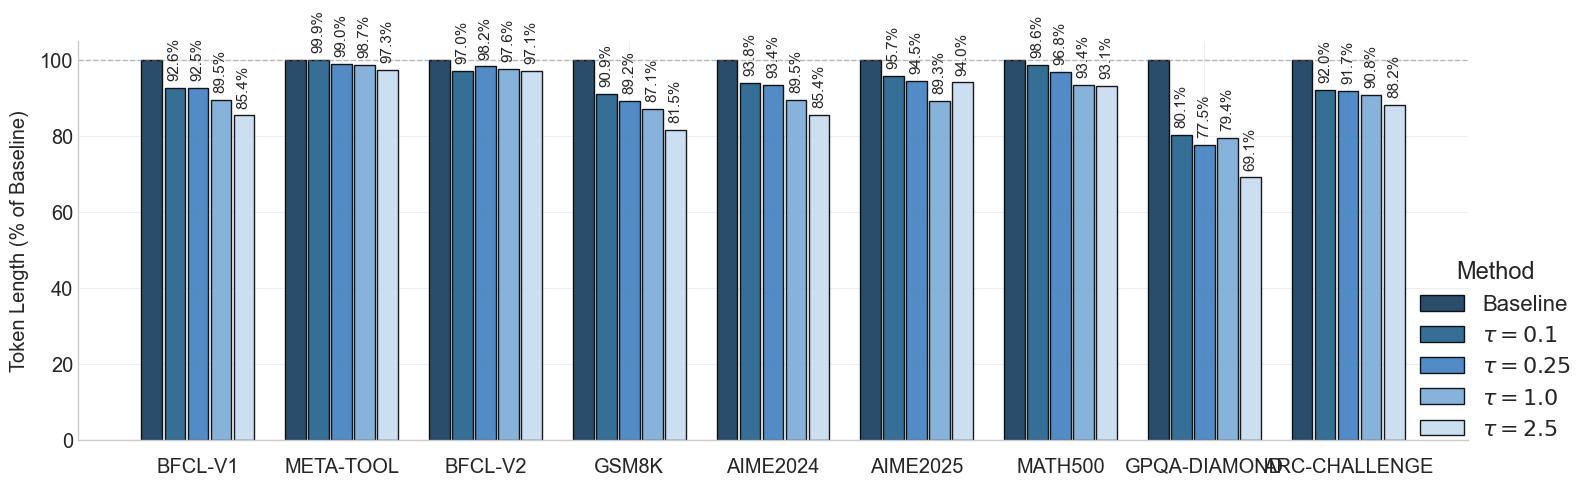

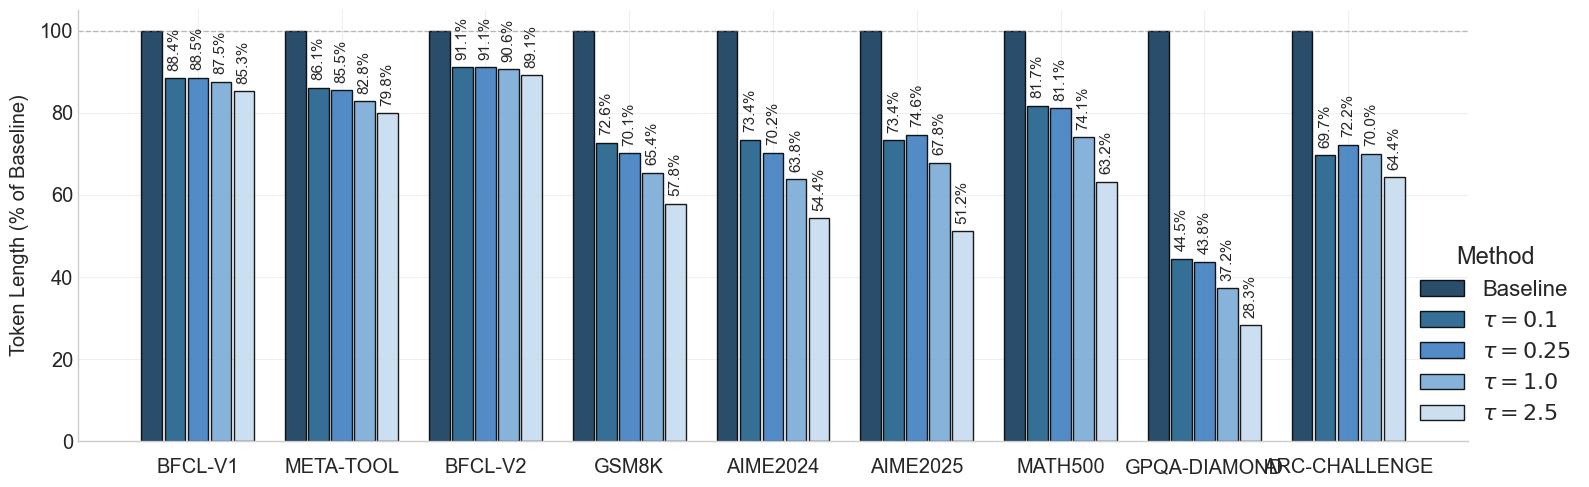

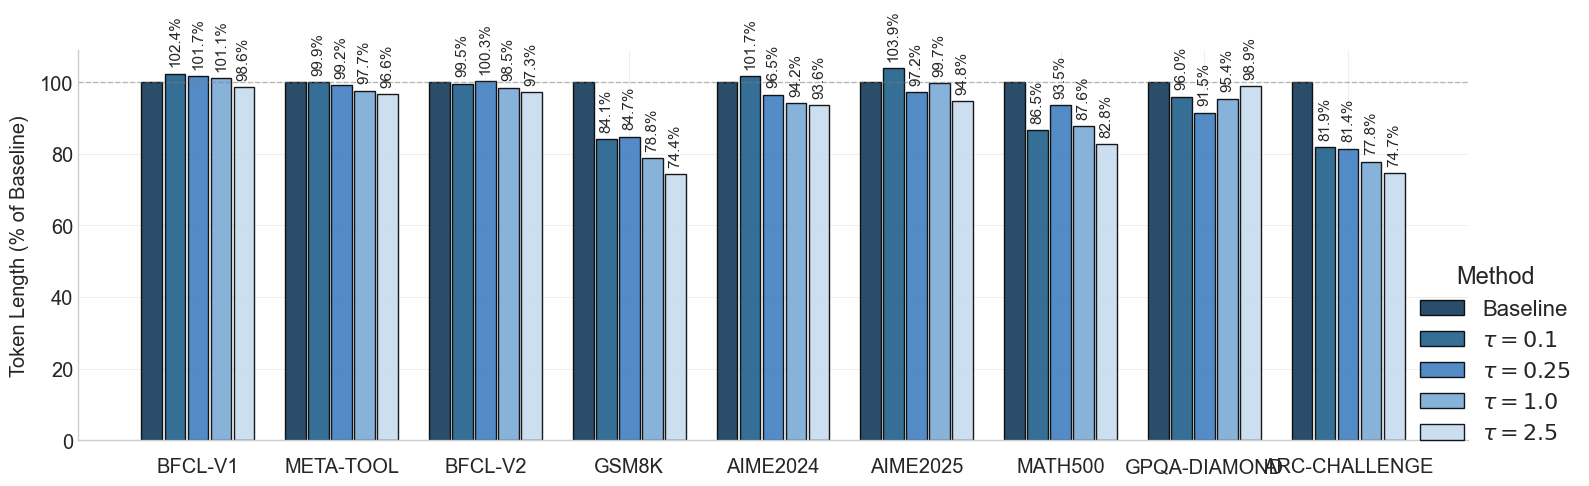

In [71]:
available_models = [m for m in INCLUDE_MODELS if _model_key(m) in thinkbrake_data]
for model in available_models:
    mk = _model_key(model)
    benchmarks_in_model = list(thinkbrake_data[mk].keys())
    n_benchmarks = len(benchmarks_in_model)
    if n_benchmarks == 0:
        continue
    # Get all threshold values
    first_benchmark = benchmarks_in_model[0]
    tb_data = thinkbrake_data[mk][first_benchmark]
    sorted_thresh_keys = sorted(tb_data.keys(), key=lambda x: float(x.split("_")[1]))
    thresholds = [k.split("_")[1] for k in sorted_thresh_keys]
    methods = ["Baseline"] + [rf"$\tau={t}$" for t in thresholds]
    fig, ax = plt.subplots(1, 1, figsize=(16, 5))
    display_name = short_names.get(mk, mk)
    model_benchmarks = []
    model_token_percentages = {m: [] for m in methods}

    for benchmark in benchmarks_in_model:
        model_benchmarks.append(benchmark.upper())
        base_val = rollout_data[mk][benchmark]["avg_token_length"]

        # Baseline is always 100%
        model_token_percentages["Baseline"].append(100.0)

        tb_data = thinkbrake_data[mk][benchmark]
        for thresh in thresholds:
            key = f"threshold_{thresh}"
            if key in tb_data:
                thresh_val = tb_data[key]["avg_token_length"]
                # Calculate percentage relative to baseline
                percentage = (thresh_val / base_val * 100) if base_val > 0 else 0
                model_token_percentages[rf"$\tau={thresh}$"].append(percentage)
            else:
                model_token_percentages[rf"$\tau={thresh}$"].append(0)

    x = np.arange(len(model_benchmarks))
    n_methods = len(methods)
    width = 0.8 / n_methods

    for i, method in enumerate(methods):
        if not model_token_percentages[method]:
            continue
        bars = ax.bar(
            x + (i - n_methods / 2 + 0.5) * width,
            model_token_percentages[method],
            width * 0.9,
            label=method,
            color=bar_colors[i % len(bar_colors)],
            edgecolor="black",
            alpha=0.9,
        )
        for bar_idx, (bar, val) in enumerate(
            zip(bars, model_token_percentages[method])
        ):
            if val > 0 and val != 100:  # Skip label for 100%
                ax.text(
                    bar.get_x() + bar.get_width() / 2,
                    bar.get_height() + max(model_token_percentages[method]) * 0.02,
                    f"{val:.1f}%",
                    ha="center",
                    va="bottom",
                    fontsize=11,
                    rotation=90,
                )

    ax.set_ylabel("Token Length (% of Baseline)", fontsize=14.4, labelpad=8)
    ax.set_xticks(x)
    ax.set_xticklabels(model_benchmarks, fontsize=14.4)
    ax.tick_params(axis="x", pad=12)
    ax.tick_params(axis="y", labelsize=14.4)

    # Add a horizontal line at 100% for reference
    ax.axhline(y=100, color="gray", linestyle="--", linewidth=1, alpha=0.5)

    ax.legend(
        loc="upper center",
        bbox_to_anchor=(1.02, 0.5),
        fontsize=16,
        framealpha=0.9,
        title="Method",
        title_fontsize=17,
    )
    ax.grid(True, axis="y", alpha=0.3)
    ax.grid(True, axis="x", alpha=0.3)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    plt.tight_layout()
    output_path = f"../assets/{display_name}_avg_token_length.pdf"
    plt.savefig(output_path, format="pdf", bbox_inches="tight", dpi=300)
    plt.show()
    plt.close(fig)

In [72]:
available_models = [m for m in INCLUDE_MODELS if _model_key(m) in thinkbrake_data]

# Prepare data for all models first (in INCLUDE_MODELS order)
all_model_data = []
for model in available_models:
    mk = _model_key(model)
    benchmarks_in_model = list(thinkbrake_data[mk].keys())
    n_benchmarks = len(benchmarks_in_model)
    if n_benchmarks == 0:
        continue
    # Get all threshold values
    first_benchmark = benchmarks_in_model[0]
    tb_data = thinkbrake_data[mk][first_benchmark]
    sorted_thresh_keys = sorted(tb_data.keys(), key=lambda x: float(x.split("_")[1]))
    thresholds = [k.split("_")[1] for k in sorted_thresh_keys]
    methods = ["Baseline"] + [rf"$\tau={t}$" for t in thresholds]
    display_name = short_names.get(mk, mk)

    # Benchmark name mapping
    benchmark_name_map = {"gpqa-diamond": "GPQA-D", "arc-challenge": "ARC-C"}

    # Define benchmark order
    benchmark_order = [
        "gsm8k",
        "math",
        "aime24",
        "aime25",
        "gpqa-diamond",
        "arc-challenge",
        "bfcl_v1",
        "bfcl_v2",
        "metatool",
    ]

    # Sort benchmarks according to the specified order
    benchmarks_sorted = []
    for b in benchmark_order:
        if b in benchmarks_in_model:
            benchmarks_sorted.append(b)
    # Add any remaining benchmarks not in the order list
    for b in benchmarks_in_model:
        if b not in benchmarks_sorted:
            benchmarks_sorted.append(b)

    model_benchmarks = []
    model_token_reductions = {m: [] for m in methods}

    for benchmark in benchmarks_sorted:
        # Apply name mapping
        display_benchmark = benchmark_name_map.get(benchmark, benchmark).upper()
        model_benchmarks.append(display_benchmark)

        base_val = rollout_data[mk][benchmark]["avg_token_length"]

        # Baseline has 0% reduction
        model_token_reductions["Baseline"].append(0.0)

        tb_data = thinkbrake_data[mk][benchmark]
        for thresh in thresholds:
            key = f"threshold_{thresh}"
            if key in tb_data:
                thresh_val = tb_data[key]["avg_token_length"]
                # Calculate reduction percentage: (baseline - method) / baseline * 100
                reduction = (
                    ((base_val - thresh_val) / base_val * 100) if base_val > 0 else 0
                )
                model_token_reductions[rf"$\tau={thresh}$"].append(reduction)
            else:
                model_token_reductions[rf"$\tau={thresh}$"].append(0)

    all_model_data.append(
        {
            "display_name": display_name,
            "model_benchmarks": model_benchmarks,
            "model_token_reductions": model_token_reductions,
            "methods": methods,
        }
    )

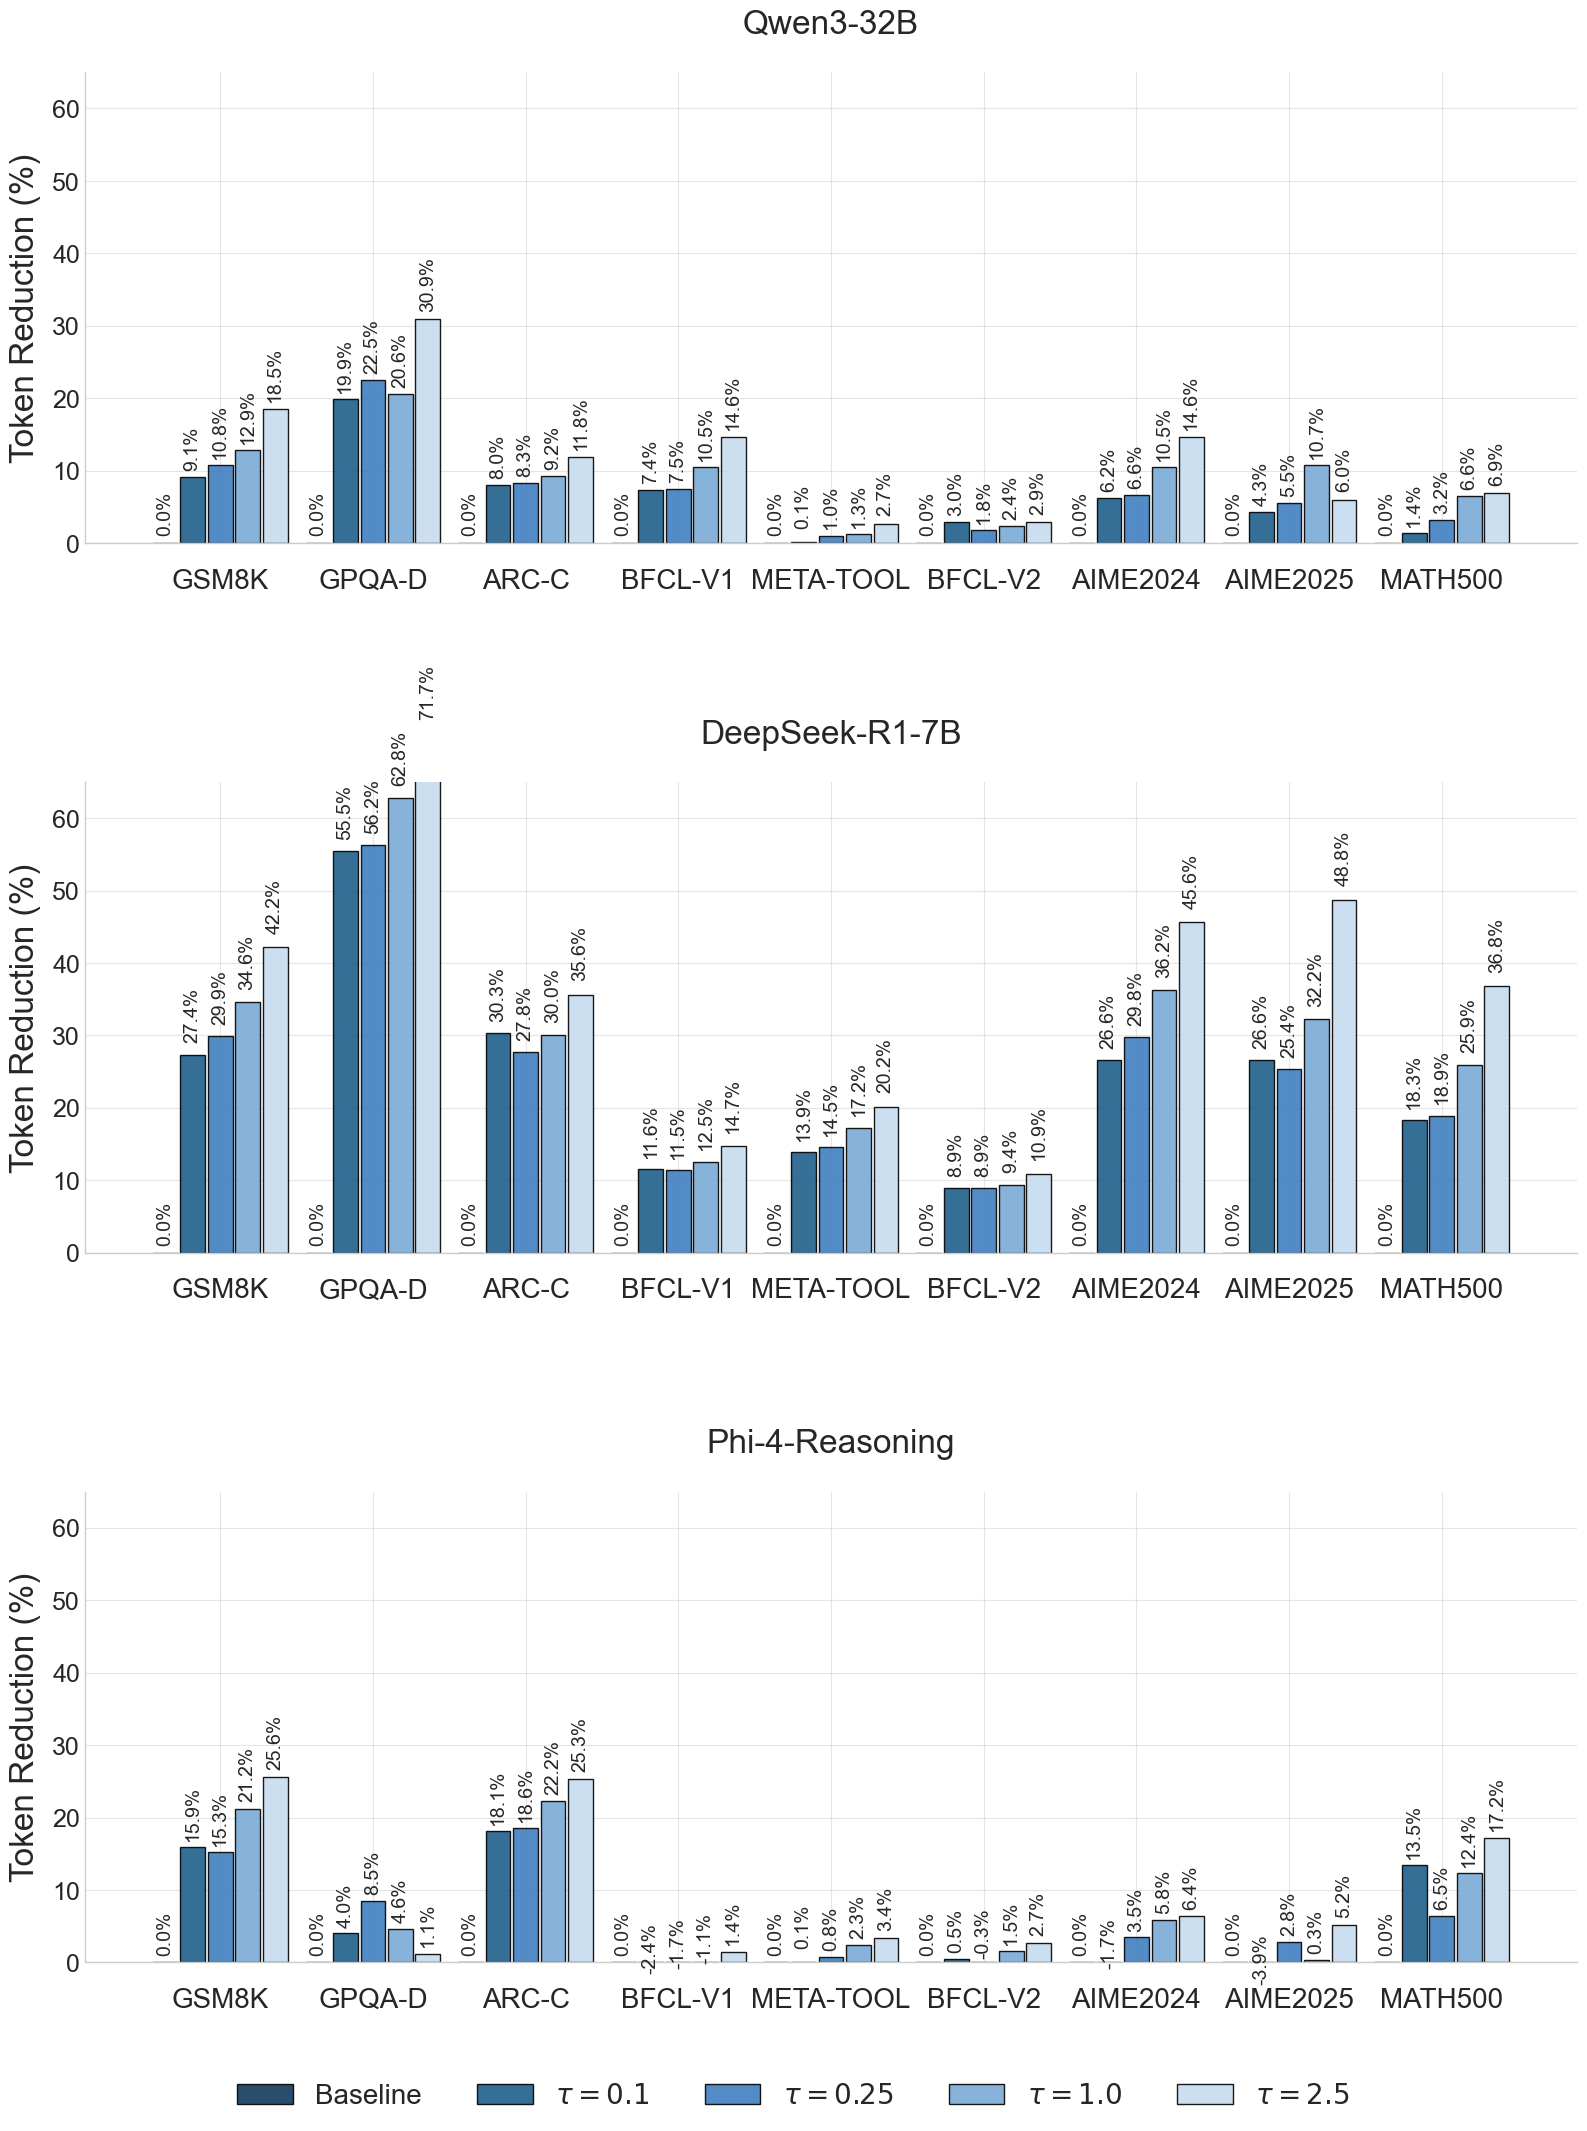

In [74]:
n_models = len(all_model_data)
if n_models > 0:
    fig, axes = plt.subplots(n_models, 1, figsize=(16, 7 * n_models))
    if n_models == 1:
        axes = [axes]

    plt.subplots_adjust(hspace=0.4)

    for ax_idx, data in enumerate(all_model_data):
        ax = axes[ax_idx]
        display_name = data["display_name"]
        model_benchmarks = data["model_benchmarks"]
        model_token_reductions = data["model_token_reductions"]
        methods = data["methods"]

        x = np.arange(len(model_benchmarks))
        n_methods = len(methods)
        width = 0.9 / n_methods

        for i, method in enumerate(methods):
            if not model_token_reductions[method]:
                continue
            bars = ax.bar(
                x + (i - n_methods / 2 + 0.5) * width,
                model_token_reductions[method],
                width * 0.9,
                label=method,
                color=bar_colors[i % len(bar_colors)],
                edgecolor="black",
                alpha=0.9,
            )
            max_val = max(model_token_reductions[method])
            for bar_idx, (bar, val) in enumerate(
                zip(bars, model_token_reductions[method])
            ):
                # Add a small offset for 0% values to lift them off the x-axis
                if abs(val) < 0.1:  # Close to 0
                    y_offset = max_val * 0.05 + 1
                else:
                    y_offset = max_val * 0.02 + 0.5

                ax.text(
                    bar.get_x() + bar.get_width() / 2,
                    bar.get_height() + y_offset,
                    f"{val:.1f}%",
                    ha="center",
                    va="bottom",
                    fontsize=14,
                    rotation=90,
                )

        ax.set_title(f"{display_name}", fontsize=24, pad=28)
        ax.set_ylabel("Token Reduction (%)", fontsize=24, labelpad=8)
        ax.set_ylim(0, 65)
        ax.set_xticks(x)
        ax.set_xticklabels(model_benchmarks, fontsize=20)
        ax.tick_params(axis="x", pad=18)
        ax.tick_params(axis="y", labelsize=18)

        ax.grid(True, axis="y", alpha=0.5)
        ax.grid(True, axis="x", alpha=0.5)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)

    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(
        handles,
        labels,
        loc="lower center",
        bbox_to_anchor=(0.5, -0.02),
        ncol=len(methods),
        frameon=False,
        fontsize=20,
    )

    plt.tight_layout(rect=[0, 0.03, 1, 1], h_pad=5)
    output_path = "../assets/token_reduction_experiment_part2.pdf"
    plt.savefig(output_path, format="pdf", bbox_inches="tight", dpi=300)
    plt.show()
    plt.close(fig)